# Capstone Project Proposal- London Cycle Hire Data

## Project Proposal:

### What is the problem you want to solve?
The pubic bike hire scheme is a great way of maximising the efficiency of public transportation systems while reducing pollution. In London, the Sanatander cycle hire scheme was started in 2010 (originally sponsored by Barclays) and it continues to be an environmentaly friendly and healthy way to explore the city or just commute. Another useful aspect of the scheme is that bikes can be hired at any time of the day and there are 839 stations densely populated around central London.

In recent years, more players are entering the cycle hire scheme such as Mobike and Ofo that offer lower pricing for short trips under 30 minutes with a more seamless experience that doesn't require docking. While we cannot change the way the bikes are tracked, we can improve overall output of the system by matching availability with demand and identifying under utilized or over utilized spaces. In a recent survey done about the public cycle hire scheme, the key consumer concerns were bike availability and space availability at docking stations (see [quarterly reports released by the scheme](https://tfl.gov.uk/corporate/publications-and-reports/cycle-hire-performance)

The key problems to solve will be:
<ol>
  <li>Understanding the current utilization of the public hire scheme using historical data</li>
  <li>Predicting the future demand for bikes at each station</li>
  <li>Use the predictive model to improve availability of bikes to maximize the output(sales - costs)</li>
</ol>
   

### Who is your client and why do they care about this problem?
In this case, my client will be Transport For London (TFL) and 

### What data are you using? How will you acquire the data?
TFL provides data on every single ride from 2012 up till August 2019 on an AWS file storage system. This is updated regularly through csv files reflecting data over 2 weeks. The data consists of the following features:
<ul style="list-style-type:circle">
  <li>Rental ID
  <li>Bike ID</li>
  <li>Start time, End time, Duration</li>
  <li>Start Station Name, End Station Name, Start Station ID, End Station ID</li>
</ul>

There is also a seperate file that gives the location data of each station (latitude, longitude) and the number of docks at each station.

The data will be downloaded through AWS file storage system, S3 using the boto module. See [AWS documentation](https://docs.aws.amazon.com/s3/?id=docs_gateway) for more information. I've included an example of downloading the data for a 2 week period in January 2016 below along with some data manipulation to get a better idea of what can be done with it.

### Brief outline of how you'll solve the problem
The problem will first require the analysis of the data. The data wrangling and analysis will mostly be done through the pandas library along with various visualization libraries to enable easier understanding of the relationships between the features. It would also require adding external parameters such as weather conditions, temperature and type of day (weekday/holiday) to better understand the trends that drive cycle hire demand. 

The second part of solving the problem would require selecting the appropriate features and using a supervised machine learning model to predict the demand. The data will be split into training and testing data with the aim of minimizing the test error.

### What are the deliverables
The deliverables are
<ol>
  <li>Code which produces a predictive model 
  <li>Report detailing the methods used to solve the problem
  <li>Presentation that summarizes the methods used</li>    
</ol>



## Mapping the locations of docking stations
I've already pre-downloaded by querying it from Google BigQuery 

In [210]:
import folium
import pandas as pd


def add_folium_markers(loc_data, map_data):
    
    for idx, data in loc_data.iterrows():
        folium.CircleMarker([data['latitude'], data['longitude']], 
                      radius =5,
                      fill=True,
                      popup="Name:{name}<br>Docks_Available:{dock_count}"
                      .format(name=data['name'], dock_count=data['docks_count'])
                      ).add_to(base_map)
        
base_map = folium.Map(location=[51.490, -0.13], control_scale=True, zoom_start=13,
                     width=1000, height=800)
df = pd.read_csv("cycle_dock_locations.csv")
map_obj = df[['latitude', 'longitude', 'name', 'docks_count']]
add_folium_markers(map_obj, base_map) 
base_map.save('cycle_docks.html')

base_map

## Downloading cycle hire trip data from https://cycling.data.tfl.gov.uk/

In [31]:
import logging
import re
import pandas as pd
import boto3
from datetime import datetime
from datetime import date
from botocore.exceptions import ClientError
from aws_keys import ACCESS_KEY, SECRET_KEY


def find_bucket_obj(bucket_name, ACCESS_KEY, SECRET_KEY):
    """find all objects in AWS S3 bucket"""

    s3 = boto3.client('s3', aws_access_key_id=ACCESS_KEY,
     aws_secret_access_key=SECRET_KEY,)
    
    try:
        response = s3.list_objects_v2(Bucket=bucket_name)
    except ClientError as e:
    # AllAccessDisabled error == bucket not found
        logging.error(e)
        return None
    
    return response

def s3_files_to_df(bucket_name, ACCESS_KEY, SECRET_KEY, key, file_name):

    s3 = boto3.client('s3', aws_access_key_id=ACCESS_KEY,
     aws_secret_access_key=SECRET_KEY,)
    
    s3.download_file(bucket_name, key, file_name)
    
    dateparser = lambda x: pd.datetime.strptime(x, "%d/%m/%Y %H:%M")
    df = pd.read_csv(file_name, parse_dates=['Start Date', 'End Date'], date_parser=dateparser)
    
    return df


bucket_name = 'cycling.data.tfl.gov.uk'
    
response = find_bucket_obj(bucket_name, ACCESS_KEY, SECRET_KEY)
    
#find files in bucket that are of type csv/zip and under usage-stats folder
file_name_generator = (bucket_dict['Key'] for bucket_dict in response['Contents'] 
                        if re.search("\Ausage-stats.*(csv|zip)", bucket_dict['Key']))
    
file_name = next(file_name_generator)
print(file_name.split('/')[1])
    
file_df = s3_files_to_df(bucket_name, ACCESS_KEY, SECRET_KEY, file_name, file_name.split('/')[1])
file_df.head()
    

01aJourneyDataExtract10Jan16-23Jan16.csv


,Rental Id,Duration,Bike Id,End Date,EndStation Id,EndStation Name,Start Date,StartStation Id,StartStation Name
0,50754225,240,11834,2016-01-10 00:04:00,383.0,"Frith Street, Soho",2016-01-10 00:00:00,18,"Drury Lane, Covent Garden"
1,50754226,300,9648,2016-01-10 00:05:00,719.0,"Victoria Park Road, Hackney Central",2016-01-10 00:00:00,479,"Pott Street, Bethnal Green"
2,50754227,1200,10689,2016-01-10 00:20:00,272.0,"Baylis Road, Waterloo",2016-01-10 00:00:00,425,"Harrington Square 2, Camden Town"
3,50754228,780,8593,2016-01-10 00:14:00,471.0,"Hewison Street, Old Ford",2016-01-10 00:01:00,487,"Canton Street, Poplar"
4,50754229,600,8619,2016-01-10 00:11:00,399.0,"Brick Lane Market, Shoreditch",2016-01-10 00:01:00,501,"Cephas Street, Bethnal Green"


In [32]:
file_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284587 entries, 0 to 284586
Data columns (total 9 columns):
Rental Id            284587 non-null int64
Duration             284587 non-null int64
Bike Id              284587 non-null int64
End Date             284587 non-null datetime64[ns]
EndStation Id        284570 non-null float64
EndStation Name      284570 non-null object
Start Date           284587 non-null datetime64[ns]
StartStation Id      284587 non-null int64
StartStation Name    284587 non-null object
dtypes: datetime64[ns](2), float64(1), int64(4), object(2)
memory usage: 19.5+ MB


### Visualising total rides and average ride time per day

In [33]:
from collections import Counter
from collections import defaultdict


rides_count = defaultdict(int)
duration_count = defaultdict(int)
for idx, data in file_df.iterrows():
    start_date = data['Start Date']
    end_date = data['End Date']
    rides_count[start_date.date()] +=1
    duration_count[start_date.date()] += (end_date - start_date).seconds


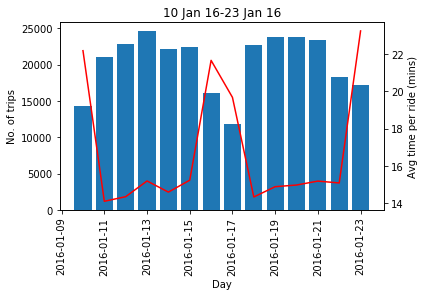

In [34]:
import matplotlib.pyplot as plt


def plot_trip_data(rides_dict, time_dict, plt_title):
    
    fig, ax1 = plt.subplots()
    plt.xticks(rotation=90)

    ax1.set_xlabel('Day')
    ax1.set_ylabel('No. of trips')
    ax1.bar(rides_dict.keys(), rides_dict.values())

    ax2 = ax1.twinx()

    ax2.set_xlabel('Day')
    ax2.set_ylabel('Avg time per ride (mins)')
    ax2.plot(time_dict.index, time_dict, color='red')

    fig.tight_layout() 
    plt.title(plt_title)
    plt.show()
    
    
mean_time = pd.Series(duration_count)/pd.Series(rides_count)/60

plot_trip_data(rides_count, mean_time, plt_title='10 Jan 16-23 Jan 16')

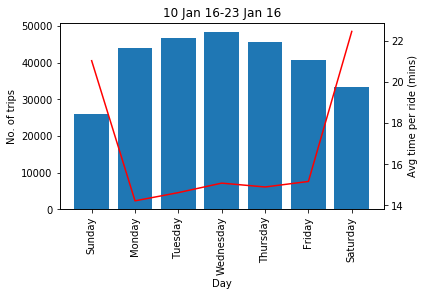

In [36]:
def change_key_to_day_name(datekey_dict):
    
    day_count = defaultdict(float)
    for idx, data in datekey_dict.items():
        day_count[idx.strftime("%A")] += data
        
    return day_count
        
rides_count_day = change_key_to_day_name(rides_count)
duration_count_day = change_key_to_day_name(duration_count)
mean_time_day = pd.Series(duration_count_day)/pd.Series(rides_count_day)/60

plot_trip_data(rides_count_day, mean_time_day, plt_title='10 Jan 16-23 Jan 16')

### Merging location data with rides data

In [45]:
location_df = pd.read_csv("cycle_dock_locations.csv")

df = pd.merge(left=file_df, right=location_df[['name', 'latitude', 'longitude']], left_on='StartStation Name', right_on='name')
merged_df = pd.merge(left=df, right=location_df[['name', 'latitude', 'longitude']], left_on='EndStation Name', right_on='name',
                suffixes=('_start', '_end')).drop(columns=['name_start', 'name_end']).sort_values(by='Start Date')

merged_df.head()

,Rental Id,Duration,Bike Id,End Date,EndStation Id,EndStation Name,Start Date,StartStation Id,StartStation Name,latitude_start,longitude_start,latitude_end,longitude_end
0,50754225,240,11834,2016-01-10 00:04:00,383.0,"Frith Street, Soho",2016-01-10 00:00:00,18,"Drury Lane, Covent Garden",51.514771,-0.122220,51.513103,-0.131214
127519,50754226,300,9648,2016-01-10 00:05:00,719.0,"Victoria Park Road, Hackney Central",2016-01-10 00:00:00,479,"Pott Street, Bethnal Green",51.527152,-0.058005,51.536425,-0.054162
17734,50754227,1200,10689,2016-01-10 00:20:00,272.0,"Baylis Road, Waterloo",2016-01-10 00:00:00,425,"Harrington Square 2, Camden Town",51.533379,-0.139159,51.501445,-0.110699
135820,50754229,600,8619,2016-01-10 00:11:00,399.0,"Brick Lane Market, Shoreditch",2016-01-10 00:01:00,501,"Cephas Street, Bethnal Green",51.522561,-0.054883,51.522618,-0.071654
160477,50754228,780,8593,2016-01-10 00:14:00,471.0,"Hewison Street, Old Ford",2016-01-10 00:01:00,487,"Canton Street, Poplar",51.511811,-0.025626,51.533283,-0.028155


### Adding distance between rides 

In [47]:
import geopy.distance

# using df.apply method; using apply is faster than using lists/deques with a for loop
def calc_route_dist(row):
  
    coords_1 = (float(row['latitude_start']), float(row['longitude_start']))
    coords_2 = (float(row['latitude_end']), float(row['longitude_end']))
    
    return geopy.distance.geodesic(coords_1, coords_2).km

route_dist = merged_df.apply(calc_route_dist, axis=1)



In [48]:
merged_df['route_dist_km'] = route_dist
merged_df.head()

,Rental Id,Duration,Bike Id,End Date,EndStation Id,EndStation Name,Start Date,StartStation Id,StartStation Name,latitude_start,longitude_start,latitude_end,longitude_end,route_dist_km
0,50754225,240,11834,2016-01-10 00:04:00,383.0,"Frith Street, Soho",2016-01-10 00:00:00,18,"Drury Lane, Covent Garden",51.514771,-0.122220,51.513103,-0.131214,0.651350
127519,50754226,300,9648,2016-01-10 00:05:00,719.0,"Victoria Park Road, Hackney Central",2016-01-10 00:00:00,479,"Pott Street, Bethnal Green",51.527152,-0.058005,51.536425,-0.054162,1.065564
17734,50754227,1200,10689,2016-01-10 00:20:00,272.0,"Baylis Road, Waterloo",2016-01-10 00:00:00,425,"Harrington Square 2, Camden Town",51.533379,-0.139159,51.501445,-0.110699,4.065241
135820,50754229,600,8619,2016-01-10 00:11:00,399.0,"Brick Lane Market, Shoreditch",2016-01-10 00:01:00,501,"Cephas Street, Bethnal Green",51.522561,-0.054883,51.522618,-0.071654,1.164025
160477,50754228,780,8593,2016-01-10 00:14:00,471.0,"Hewison Street, Old Ford",2016-01-10 00:01:00,487,"Canton Street, Poplar",51.511811,-0.025626,51.533283,-0.028155,2.395377


### Finding the most common routes

In [49]:
from collections import Counter

route_count = Counter()
for idx, data in merged_df.iterrows():
    route_count[(data['StartStation Name'], data['EndStation Name'], data['route_dist_km'])] +=1


In [50]:
print('The 10 most common routes are:')
for idx, value in route_count.most_common(10):
    print('Starting at: ' + str(idx[0]) + ' and ending at: ' + str(idx[1]))
    print('Distance between: ' + str(round(idx[2],2)) + 'km')
    print('Number of trips: ' + str(value))

The 10 most common routes are:
Starting at: Hyde Park Corner, Hyde Park and ending at: Hyde Park Corner, Hyde Park
Distance between: 0.0km
Number of trips: 296
Starting at: Albert Gate, Hyde Park and ending at: Albert Gate, Hyde Park
Distance between: 0.0km
Number of trips: 202
Starting at: Black Lion Gate, Kensington Gardens and ending at: Black Lion Gate, Kensington Gardens
Distance between: 0.0km
Number of trips: 131
Starting at: Parsons Green Station, Parsons Green and ending at: St. Peter's Terrace, Fulham
Distance between: 0.62km
Number of trips: 115
Starting at: Vauxhall Cross, Vauxhall and ending at: Riverlight North, Nine Elms
Distance between: 0.9km
Number of trips: 113
Starting at: All Saints Church, Portobello and ending at: Notting Hill Gate Station, Notting Hill
Distance between: 0.89km
Number of trips: 112
Starting at: Riverlight North, Nine Elms and ending at: Vauxhall Cross, Vauxhall
Distance between: 0.9km
Number of trips: 112
Starting at: Black Lion Gate, Kensington 